In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd 

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
df = pd.read_parquet('./data/green_tripdata_2022-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.652716560267797

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


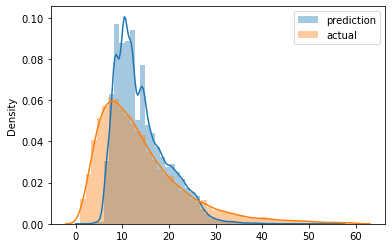

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2022-02.parquet')

In [11]:
len(df_train), len(df_val)

(59603, 66097)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.771091643673534

In [16]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)

# with open('models/dv.pkl', 'wb') as f_out:
#     pickle.dump(dv, f_out)

In [17]:
lr = Lasso(0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.475775217343405

In [18]:
import mlflow

In [19]:
mlflow.get_registry_uri()

'file:///workspaces/mlops-zoomcamp-2025/mlruns'

 ### mlflow ui --backend-store-uri sqlite:///mlflow.db

In [20]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')  # Set the tracking URI to a valid SQLite database
mlflow.set_experiment('nyc-taxi-experiment')   # Set the experiment name

<Experiment: artifact_location='/workspaces/mlops-zoomcamp-2025/mlruns/1', creation_time=1745700092379, experiment_id='1', last_update_time=1745700092379, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [21]:
from mlflow.models.signature import infer_signature

signature = infer_signature(X_val, y_pred)

mlflow.start_run()

mlflow.log_param('train-data-path', './data/green_tripdata_2022-01.parquet')
mlflow.log_param('valid-data-path', './data/green_tripdata_2022-02.parquet')
mlflow.log_param('model-type', 'linear-regression')
mlflow.log_param('model-algorithm', 'lasso')
mlflow.set_tag('developer', 'jaswanth')

# Log model parameters individually
for param_name, param_value in lr.get_params().items():
    mlflow.log_param(f'model-param-{param_name}', param_value)

mlflow.log_metric('rmse', root_mean_squared_error(y_val, y_pred))
mlflow.sklearn.log_model(lr, 'model', signature=signature)

# Log DictVectorizer as an artifact
with open('dv.pkl', 'wb') as f_out:
    pickle.dump(dv, f_out)
    
mlflow.log_artifact('dv.pkl', artifact_path='preprocessor')

mlflow.end_run()

2025/04/26 20:56:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp__gg4nzl/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 


In [21]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:

import mlflow.xgboost


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.xgboost.autolog()
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,
            evals=[(valid, 'validation')],
            early_stopping_rounds=2
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=2,
    trials=Trials()
)

[0]	validation-rmse:9.37680                                                                                             
  0%|                                                                             | 0/2 [00:02<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.85498                                                                                             
[2]	validation-rmse:8.41301                                                                                             
[3]	validation-rmse:8.03914                                                                                             
[4]	validation-rmse:7.72541                                                                                             
[5]	validation-rmse:7.46321                                                                                             
[6]	validation-rmse:7.24413                                                                                             
[7]	validation-rmse:7.06197                                                                                             
[8]	validation-rmse:6.91050                                                                                             
[9]	validation-rmse:6.78534     

2025/04/27 21:43:16 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/04/27 21:43:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/04/27 21:43:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpezof3pwo/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 

2025/04/27 21:43:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when loggin

[0]	validation-rmse:9.44615                                                                                             
[1]	validation-rmse:8.97360                                                                                             
 50%|██████████████████████████                          | 1/2 [00:13<00:11, 11.20s/trial, best loss: 6.785337601068868]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.56680                                                                                             
[3]	validation-rmse:8.21607                                                                                             
[4]	validation-rmse:7.91802                                                                                             
[5]	validation-rmse:7.66203                                                                                             
[6]	validation-rmse:7.44069                                                                                             
[7]	validation-rmse:7.25312                                                                                             
[8]	validation-rmse:7.09506                                                                                             
[9]	validation-rmse:6.96123                                                                                             
 50%|██████████████████████████ 

2025/04/27 21:43:26 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/04/27 21:43:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/04/27 21:43:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmps6816sbq/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 

2025/04/27 21:43:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when loggin

100%|████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.50s/trial, best loss: 6.785337601068868]


# Training with best params

In [24]:
params = {
    'max_depth': 17,
    'learning_rate': 0.2,
    'reg_alpha': 0.28,
    'reg_lambda': 0.004,
    'min_child_weight': 1.24,
    'objective': 'reg:linear',
    'seed': 42
}


with mlflow.start_run():
    mlflow.set_tag("model", "xgboost")
    mlflow.xgboost.autolog()
    
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=20
    )



/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:41:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.87124
[1]	validation-rmse:8.05824
[2]	validation-rmse:7.47088
[3]	validation-rmse:7.05561
[4]	validation-rmse:6.76560
[5]	validation-rmse:6.56167
[6]	validation-rmse:6.41831
[7]	validation-rmse:6.31519
[8]	validation-rmse:6.24094
[9]	validation-rmse:6.18307
[10]	validation-rmse:6.14108
[11]	validation-rmse:6.10778
[12]	validation-rmse:6.08314
[13]	validation-rmse:6.05954
[14]	validation-rmse:6.04797
[15]	validation-rmse:6.03729
[16]	validation-rmse:6.02776
[17]	validation-rmse:6.02217
[18]	validation-rmse:6.01738
[19]	validation-rmse:6.01664
[20]	validation-rmse:6.01004
[21]	validation-rmse:6.00982
[22]	validation-rmse:6.00768
[23]	validation-rmse:6.00766
[24]	validation-rmse:6.00485
[25]	validation-rmse:6.00443
[26]	validation-rmse:6.00334
[27]	validation-rmse:6.00229
[28]	validation-rmse:6.00040
[29]	validation-rmse:5.99863
[30]	validation-rmse:5.99724
[31]	validation-rmse:5.99578
[32]	validation-rmse:5.99378
[33]	validation-rmse:5.99230
[34]	validation-rmse:5.9

2025/04/27 21:41:33 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/04/27 21:41:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:41:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/04/27 21:41:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpusxbon75/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 21:41:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

In [28]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

FileNotFoundError: [Errno 2] No such file or directory: 'models/preprocessor.b'